# Transformer language model implementation

This notebook shows how to implement and train a decoder-only transformer for language modeling. It was created to deepen my own understanding of transformers, but I hope it can also be a helpful resource for others wanting to learn more about transformers.


## Getting started

If you're opening this Notebook on colab, you will need to clone the repo and change working directory. Update the `do_clone` variable below to `True` run the cell.


In [158]:
do_clone = False

if do_clone:
    !git clone https://github.com/jbergq/transformer.git
    %cd transformer

In [159]:
%%capture
%pip install portalocker
%pip install -r requirements.txt
%pip install pyarrow
%pip install --upgrade numpy

In [160]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now, let's create a configuration class that we will use to configure the remaining code in the notebook.


In [161]:
from dataclasses import dataclass, asdict
from pprint import pprint


# Define base config. Partly adopted from nanoGPT by Andrej Karpathy
@dataclass
class Config:
    model_name: str = "toy-model"
    val_size: int = 1000  # Size of validation set.
    max_iters: int = 600000  # Total num training iterations.
    eval_iters: int = 100  # Number of evaluation iterations.
    eval_interval: int = 1000
    effective_batch_size: int = 512
    batch_size: int = 4
    grad_accum_steps: int = 1
    lr: float = 1e-3
    warmup_iters: int = 2000
    lr_decay_iters: int = 600000  # Should be ~= max_iters per Chinchilla.
    min_lr: float = 6e-5  # Minimum lr, should be ~= lr/10 per Chinchilla.
    weight_decay: float = 0.0005
    print_example: bool = True


cfg = Config()

# Derive accumulation steps to get target effective batch size.
if cfg.effective_batch_size is not None:
    cfg.grad_accum_steps = cfg.effective_batch_size // cfg.batch_size

if cfg.model_name == "toy-model":
    cfg.context_size = 64
    cfg.embedding_size = 128
    cfg.ff_hidden_size = 256
    cfg.head_size = None
    cfg.num_blocks = 4
    cfg.num_heads = 4
elif cfg.model_name == "gpt2-small-custom":
    cfg.context_size = 1024
    cfg.embedding_size = 768
    cfg.ff_hidden_size = 3072
    cfg.head_size = None
    cfg.num_blocks = 12
    cfg.num_heads = 12

if cfg.head_size is None:
    cfg.head_size = cfg.embedding_size // cfg.num_heads

asdict(cfg)

{'model_name': 'toy-model',
 'val_size': 1000,
 'max_iters': 600000,
 'eval_iters': 100,
 'eval_interval': 1000,
 'effective_batch_size': 512,
 'batch_size': 4,
 'grad_accum_steps': 128,
 'lr': 0.001,
 'warmup_iters': 2000,
 'lr_decay_iters': 600000,
 'min_lr': 6e-05,
 'weight_decay': 0.0005,
 'print_example': True}

### Dataset

We will now set up the training and validation datasets. We will use Hugging Face's `datasets` package to prepare and load the WebText dataset.

In [162]:
from datasets import load_dataset

# Load WebText dataset in streaming mode. No need to download!
dataset = load_dataset("openwebtext", streaming=True)["train"]
shuffled_dataset = dataset.shuffle(seed=42, buffer_size=10000)

# Split dataset.
train_set = shuffled_dataset.skip(cfg.val_size)
val_set = shuffled_dataset.take(cfg.val_size)

Next, we want to convert the dataset into a numeric format that is easier for our model to work with. This process is called _tokenizing_ the dataset.

To do this, we will use the GPT-2 tokenizer available from Hugging Face's `transformers` package. It is a *subword* tokenizer, where tokens can represent either full words or word pieces.


In [163]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.vocab_size

50257

Below we define a function called `tokenize` for turning text documents from the dataset into the example input and output sequences for training the model. We will be training a language model which simply predicts the next token in a sequence given the tokens so far as input. Therefore, input sequences will just be the target sequences shifted by one index to the left.


In [164]:
from functools import partial


def tokenize(example):
    outputs = tokenizer(
        example["text"],
        truncation=True,  # Truncate returned token sequences to max_length.
        max_length=cfg.context_size + 1,  # Max length of returned token sequences.
        return_overflowing_tokens=True,  # Tokenize whole input and split into chunks.
        return_length=True,  # Return lengths of chunks.
    )

    # Create examples.
    inp_batch = []
    tgt_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == cfg.context_size + 1:  # Only include full length sequences.
            inp_batch.append(input_ids[:-1])
            tgt_batch.append(input_ids[1:])  # Note: input shifted by one.

    return {"input": inp_batch, "target": tgt_batch}


# Tokenize train and val sets.
train_tokenized = train_set.map(
    partial(tokenize),
    batched=True,
    remove_columns=train_set.column_names,
)
val_tokenized = val_set.map(
    partial(tokenize),
    batched=True,
    remove_columns=val_set.column_names,
)

We will use an "infinite training loop" to train the transformer language model, where we continue to sample random batches until we reach convergence or the maximum number of batches configured.

Let's create a dataset wrapper that will allow us to continue sampling the dataset endlessly.


In [165]:
from typing import Iterator

from torch.utils.data import IterableDataset


class InfiniteIterableDataset(IterableDataset):
    def __init__(self, hf_dataset, shuffle=False):
        self.hf_dataset = hf_dataset

    def __iter__(self) -> Iterator:
        while True:
            for item in self.hf_dataset:
                yield item

Finally, we create data loaders to sample batches from the datasets.


In [166]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    InfiniteIterableDataset(train_tokenized),
    batch_size=cfg.batch_size,
    collate_fn=lambda samples: {
        "input": torch.tensor([sample["input"] for sample in samples]),
        "target": torch.tensor([sample["target"] for sample in samples]),
    },
)
val_loader = DataLoader(
    InfiniteIterableDataset(val_tokenized),
    batch_size=cfg.batch_size,
    collate_fn=lambda samples: {
        "input": torch.tensor([sample["input"] for sample in samples]),
        "target": torch.tensor([sample["target"] for sample in samples]),
    },
)

train_iter = iter(train_loader)
val_iter = iter(train_iter)

Load a train batch and a validation batch to make sure everything works.


In [167]:
batch_train = next(train_iter)

print("Input sequence: ", batch_train["input"][0][:10])
print("Target sequence: ", batch_train["target"][0][:10])

Input sequence:  tensor([47976, 33265,    11,  5267,    13,   362,   357,    34,  4535,     8])
Target sequence:  tensor([33265,    11,  5267,    13,   362,   357,    34,  4535,     8,  6185])


In [168]:
batch_val = next(val_iter)

print("Input sequence: ", batch_val["input"][0][:10])
print("Target sequence: ", batch_val["target"][0][:10])

Input sequence:  tensor([12256, 35359, 23983,   968, 23222, 13072,  4482,   198,   198,   464])
Target sequence:  tensor([35359, 23983,   968, 23222, 13072,  4482,   198,   198,   464,  1380])


Great, it seems to work! Notice how the target sequences are just input sequences shifted one step to the left.

Next, let's take a look at implementing the transformer model we will be training.


## Model implementation


This section shows how to implement a transformer decoder, the version of the transformer suitable for language modeling.


### Transformer decoder

Despite what one may think, transformers are actually very simple neural network architectures. We will be implementing a decoder-only transformer, the same type as the GPT family, which is arguably the simplest type of transformer.

The diagram below shows the components of a transformer decoder (image adopted from original transformer paper).

<img src="images/transformer_decoder.png" height=720></img>

We see that there are only a few constituent parts that make up the model architecture:

- An initial token embedding layer
- $N$ transformer decoder blocks stacked sequentially
- A final classification head

Let's take a deeper look at these in the sections below.


### Token embeddings

We start with the first layer — token embeddings.

<img src="images/embedding.png"></img>

This layer maps each token in the input sequence to learned vector representations called embeddings. Once trained, these embeddings can be thought of as representing various linguistic features of each token in the input, such as whether it is a verb, noun or adjective, singular or plural, etc. Since tokens with similar meaning will likely share a number of linguistic features, this also means that their embeddings are likely to be in close proximity in the embedding space. Embeddings therefore also provide a mathematical representation of the relatedness _between_ different tokens.

Let's implement a simple token embedding using PyTorch's built-in `nn.Embedding` module. It is essentially a huge lookup table, with each row being the embedding vector for the token with that row number as value. The embeddings consist of parameters that can be trained via normal backpropagation. Since there are `vocab_size` tokens and each embedding has size `embedding_dim`, the embedding table has shape `(vocab_size, embedding_dim)`.


In [169]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, tokens):
        return self.embedding(tokens)

So is that it? Not quite. While we could train our transformer with only token embeddings, the transformer architecture itself has no notion of the _positions_ of tokens in the sqeuence. In natural language, the order of words can completely change the meaning of a sentence, so it is necessary to give our transformer a way to represent this. A common way to address this is to create another embedding that is simply added onto the token embeddings to inject information about its position, called a _positional encoding_.

Let's see how it can be implemented. For a sequence length of $T$, we want to generate $T$ vectors that can uniquely represent each position in the sequence. We also want TODO.


In [170]:
class PositionalEncoding(nn.Module):
    def __init__(self, context_size, embedding_size, n=10000):
        super().__init__()

        i = torch.arange(embedding_size // 2)
        k = torch.arange(context_size).unsqueeze(dim=1)

        pos_embeddings = torch.zeros(context_size, embedding_size, requires_grad=False)
        pos_embeddings[:, 0::2] = torch.sin(k / (n ** (2 * i / embedding_size)))
        pos_embeddings[:, 1::2] = torch.cos(k / (n ** (2 * i / embedding_size)))

        self.register_buffer("pos_embeddings", pos_embeddings)

    def forward(self, x):
        return self.pos_embeddings[: x.shape[1], :]

Let's create a single layer called a `TransformerEmbedding` that combines both of these embeddings.


In [171]:
class TransformerEmbedding(nn.Module):
    def __init__(self, hidden_size, vocab_size, context_size) -> None:
        super().__init__()

        self.token_embedding = TokenEmbedding(vocab_size, hidden_size)
        self.pos_embedding = PositionalEncoding(context_size, hidden_size)

    def forward(self, x):
        return self.token_embedding(x) + self.pos_embedding(x)

### Transformer blocks

Next, we take a look at the decoder transformer block.

<img src="images/transformer_block.png"></img>

Transformers, like many other neural networks, are made by stacking multiple computational blocks in a sequence. For decoder-type transformers, the blocks contain two main components:

- A masked multi-head attention module, responsible for communication between token embeddings.
- A feedforward module, responsible for processing token embeddings.

By alternating between inter-token communication and per-token processing, transformers are able to produce sophisticated representations of language.

For decoder transformer blocks in particular, they have a single property that defines them: they use _masked_ attention. This means that any given token only attends to the tokens that precede it, making the attention _causal_. More on this later.


#### Scaled dot product attention

Attention is perhaps the most characteristic and important feature of transformers. _Self-attention_ in particular allows transformers to learn representation of the contextual relationships between tokens in the input sequence.

The most common form of self-attention is called scaled dot product attention. Let's see how we can implement it.

For _each_ token embedding in the input sequence, we compute three new embeddings of the same size: a query _Q_, a key _K_ and value _V_. These are computed by learned functions in the form of simple `nn.Linear` layers. However, for this implementation the linear layers are placed outside of the scaled dot product attention module (more on this soon), so we simply assume the _Q_, _K_ and _V_ are provided as input.

TODO finish


In [172]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None):
        batch_size, head, seq_length, head_size = k.shape

        score = (q @ k.transpose(2, 3)) / math.sqrt(head_size)

        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)

        score = self.softmax(score)

        return score @ v

#### Masked multi-head attention


In [173]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_size, head_size, num_heads=8):
        super().__init__()

        self.head_size = head_size
        self.num_heads = num_heads

        self.attention = ScaledDotProductAttention()

        self.lin_q = nn.Linear(embedding_size, head_size * num_heads)
        self.lin_k = nn.Linear(embedding_size, head_size * num_heads)
        self.lin_v = nn.Linear(embedding_size, head_size * num_heads)

        self.lin_concat = nn.Linear(head_size * num_heads, embedding_size)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.lin_q(q), self.lin_k(k), self.lin_v(v)
        q, k, v = self.split(q), self.split(k), self.split(v)

        out = self.attention(q, k, v, mask)

        out = self.concat(out)
        out = self.lin_concat(out)

        return out

    def split(self, x):
        batch_size, seq_len, hidden_size = x.shape

        return x.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)

    def concat(self, x):
        batch_size, num_heads, seq_len, head_size = x.shape
        hidden_size = head_size * num_heads

        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, hidden_size)

#### Feedforward block


In [174]:
class FeedForward(nn.Module):
    def __init__(self, in_size, hidden_size, dropout_prob=0.1):
        super().__init__()

        self.lin1 = nn.Linear(in_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.lin2 = nn.Linear(hidden_size, in_size)

    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.lin2(x)

        return x

#### Putting it all together


In [175]:
class DecoderBlock(nn.Module):
    def __init__(
        self,
        hidden_size,
        ff_hidden_size,
        head_size,
        num_heads,
        dropout_prob=0.1,
        layer_norm_eps=1e-5,
    ):
        super().__init__()

        self.attention1 = MultiHeadAttention(hidden_size, head_size, num_heads)
        self.norm1 = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.ff_block = FeedForward(hidden_size, ff_hidden_size, dropout_prob)

        self.norm3 = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.dropout3 = nn.Dropout(dropout_prob)

    def forward(self, x, lookahead_mask=None):
        x_n = self.norm1(x)
        x_a = self.attention1(q=x_n, k=x_n, v=x_n, mask=lookahead_mask)

        x = self.dropout1(x + x_a)

        x_f = self.ff_block(self.norm3(x))

        x = self.dropout3(x + x_f)

        return x

In [176]:
class Classifier(nn.Module):
    def __init__(self, hidden_size, vocab_size) -> None:
        super().__init__()

        self.ln_final = nn.LayerNorm(hidden_size)
        self.lin_final = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.ln_final(x)
        x = self.lin_final(x)

        return x

In [177]:
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        context_size,
        embedding_size,
        ff_hidden_size,
        head_size,
        num_blocks=5,
        num_heads=8,
    ):
        super().__init__()
        self.register_buffer("tri", torch.tril(torch.ones(context_size, context_size)))

        self.embedding = TransformerEmbedding(embedding_size, vocab_size, context_size)

        self.decoder = []
        for _ in range(num_blocks):
            self.decoder.append(DecoderBlock(embedding_size, ff_hidden_size, head_size, num_heads))
        self.decoder = nn.ModuleList(self.decoder)

        self.classifier = Classifier(embedding_size, vocab_size)

    def create_lookahead_mask(self, tgt_seq_len):
        return self.tri[:tgt_seq_len, :tgt_seq_len].unsqueeze(0)

    def forward(self, x):
        lookahead_mask = self.create_lookahead_mask(x.shape[1])

        x = self.embedding(x)

        for block in self.decoder:
            x = block(x, lookahead_mask)

        out = self.classifier(x)

        return out

## Training


### Util functions


In [178]:
def count_model_params(model):
    total_params = 0
    for params in list(model.parameters()):
        num = 1
        for size in list(params.size()):
            num = num * size
        total_params += num
    return total_params

In [179]:
# Loss estimation function inspired by nanoGPT repo by Andrej Karpathy.
@torch.no_grad()
def estimate_loss(model, criterion, train_iter, val_iter, num_iters):
    iterators = {"train": train_iter, "val": val_iter}
    loss_dict = {}
    model.eval()
    for split, iterator in iterators.items():
        losses = torch.zeros(num_iters)
        for k in range(num_iters):
            batch = next(iterator)
            inp, tgt = batch["input"].to(device), batch["target"].to(device)

            out = model(inp)

            out_reshape = out.contiguous().view(-1, out.shape[-1])  # (B * T, vocab_size)
            tgt_reshape = tgt.contiguous().view(-1)  # (B * T, 1)

            loss = criterion(out_reshape, tgt_reshape)
            losses[k] = loss.item()
        loss_dict[split] = losses.mean()
    model.train()

    return loss_dict

In [180]:
# Learning rate decay scheduler inspired by nanoGPT repo by Andrej Karpathy.
def get_lr(iter, warmup_iters, base_lr, min_lr, lr_decay_iters):
    # 1) linear warmup for warmup_iters steps
    if iter < warmup_iters:
        return base_lr * iter / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if iter > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (iter - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return min_lr + coeff * (base_lr - min_lr)

In [181]:
@torch.no_grad()
def generate(model, inp_seq, context_size, max_output_len=100):
    seq = inp_seq

    for _ in range(max_output_len):
        out = model(seq[..., -context_size:])  # Truncate input sequence to max length.
        probs = F.softmax(out[:, -1, :], dim=1)
        next_tokens = torch.multinomial(probs, num_samples=1)

        # Append the next tokens to the generated sequences.
        seq = torch.cat((seq, next_tokens), dim=-1)

    return seq

In [182]:
def train_start_print(model):
    e_string = "=" * 45

    num_params = count_model_params(model)
    num_params_m = num_params / 1e6

    print("\n" + e_string)
    print("Starting training!")
    print("Num model params: {num_params_m:.3f}M".format(num_params_m=num_params_m))
    print(e_string + "\n")


def iter_print(iter, train_loss, newline_interval=50):
    l_string = "-" * 45
    f_str = "{: <10} {: <10.5}"

    if iter % 500 == 0:
        print(l_string)
        print(f_str.format("Iter", "Train loss"))
        print(l_string)
    print(f_str.format(iter, train_loss), end="\r" if iter % newline_interval else "\n")


def evaluation_print(losses):
    e_string = "=" * 45

    print("\n\n" + e_string)
    print("Evaluation done!")
    print("Mean train loss: {mean_loss:.3f}".format(mean_loss=losses["train"]))
    print("Mean validation loss: {mean_loss:.3f}".format(mean_loss=losses["val"]))
    print(e_string + "\n")

### Training loop


In [183]:
model = TransformerDecoder(
    vocab_size=tokenizer.vocab_size,
    context_size=cfg.context_size,
    embedding_size=cfg.embedding_size,
    ff_hidden_size=cfg.ff_hidden_size,
    head_size=cfg.head_size,
    num_blocks=cfg.num_blocks,
    num_heads=cfg.num_heads,
)
model = model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, eps=5e-9)
criterion = nn.CrossEntropyLoss(ignore_index=1)

Text(0, 0.5, 'lr')

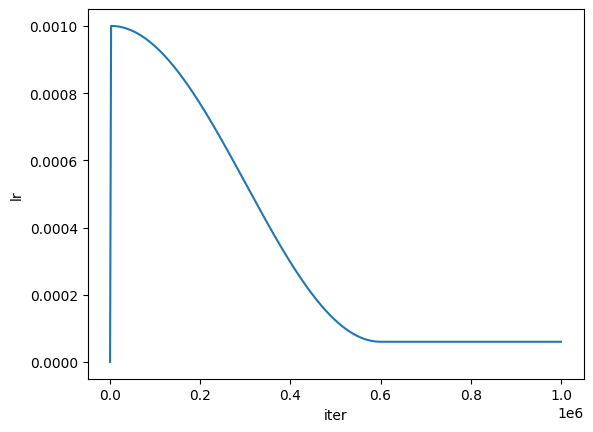

In [184]:
import matplotlib.pyplot as plt

lrs = [
    get_lr(
        iter,
        warmup_iters=cfg.warmup_iters,
        base_lr=cfg.lr,
        min_lr=cfg.min_lr,
        lr_decay_iters=cfg.lr_decay_iters,
    )
    for iter in range(0, 1_000_000, 1)
]
plt.plot(lrs)
plt.xlabel("iter")
plt.ylabel("lr")

To get an estimate for what loss values are reasonable to reach, let's load the original GPT-2 using HuggingFace and evaluate it with a few samples.


In [185]:
from transformers import AutoModelWithLMHead, AutoConfig


class GPT2Wrapped(nn.Module):
    def __init__(self, pretrained=False) -> None:
        super().__init__()
        if pretrained:
            self.model = AutoModelWithLMHead.from_pretrained("gpt2")
        else:
            config = AutoConfig.from_pretrained("gpt2")
            self.model = AutoModelWithLMHead.from_config(config)

        self.context_size = self.model.config.n_ctx

    def forward(self, x):
        return self.model(x).logits


gpt2 = GPT2Wrapped(pretrained=True)

losses = estimate_loss(gpt2, criterion, train_iter, val_iter, 100)
losses

{'train': tensor(3.5675), 'val': tensor(3.5477)}

We see that the pre-trained GPT-2 reaches a fairly impressive train and validation loss of about 3.5.


In [186]:
fixed_inp = torch.tensor(tokenizer.encode("The"), dtype=torch.long, device=device).unsqueeze(0)

if cfg.print_example:
    batch = next(iter(train_loader))
    out = generate(model, fixed_inp, cfg.context_size)

    print("Example sequence: ", tokenizer.decode(batch["target"][0].numpy())[:200])
    print("Model output: ", tokenizer.decode(out[0].detach().cpu().numpy())[:200])

# Reinitialize data iterators.
train_iter = iter(train_loader)
val_iter = iter(train_iter)

iter_num = 0
best_val_loss = float("inf")

# Start training.
train_start_print(model)


while True:
    # Get learning rate according to schedule.
    lr = get_lr(
        iter_num,
        warmup_iters=cfg.warmup_iters,
        base_lr=cfg.lr,
        min_lr=cfg.min_lr,
        lr_decay_iters=cfg.lr_decay_iters,
    )

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    # Train model on one batch.
    batch = next(train_iter)
    inp, tgt = batch["input"].to(device), batch["target"].to(device)

    out = model(inp)

    out_reshape = out.contiguous().view(-1, out.shape[-1])  # (B * T, vocab_size)
    tgt_reshape = tgt.contiguous().view(-1)  # (B * T, 1)

    train_loss = criterion(out_reshape, tgt_reshape)
    train_loss.backward()

    # Accumulate gradients for N steps and update weights.
    if (iter_num + 1) % cfg.grad_accum_steps == 0:
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    if iter_num > 0 and iter_num % cfg.eval_interval == 0:
        losses = estimate_loss(model, criterion, train_iter, val_iter, cfg.eval_iters)
        evaluation_print(losses)

        # Generate sample and print.
        out = generate(model, fixed_inp, cfg.context_size)
        print("Model output: ", tokenizer.decode(out[0].detach().cpu().numpy())[:200])

        # Save model checkpoint if new best validation loss.
        if losses["val"] < best_val_loss:
            torch.save(
                {
                    "iter": iter_num,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                "best.pth",
            )

    iter_print(iter_num, train_loss)
    iter_num += 1

Example sequence:  pei, Nov. 2 (CNA) Bitcoin is illegal in Taiwan, said Financial Supervisory Commission (FSC) Chairman Tseng Ming-chung (曾銘宗) on Monday after kidnappers in Taiwan tried to collect a ransom through the v
Model output:  The Koen AVGVolume alum Adams Debor MUS crochet Knifecould Graph SPR unconstitutional Haas Pixar frameworkspat drum ICE Las mysterious Apocalypse Influence 58 utilitarianerofp didnt broadcaster cease 

Starting training!
Num model params: 13.446M

---------------------------------------------
Iter       Train     
---------------------------------------------
0          11.001    
50         11.028    
100        10.971    
150        10.974    
200        10.979    
250        11.031    
300        10.886    
350        10.93     
400        10.939    
450        10.959    
---------------------------------------------
Iter       Train     
---------------------------------------------
500        10.926    
550        10.828    
600        10.82     
650

KeyboardInterrupt: 